In [ ]:
#default_exp callback.mixup

In [ ]:
#export
from local.test import *
from local.basics import *
from local.callback.progress import *
from local.vision.core import *

from torch.distributions.beta import Beta

In [ ]:
from local.notebook.showdoc import *
from local.test_utils import *

# Mixup callback

> Callback to apply MixUp data augmentation to your training

## MixupCallback -

In [ ]:
# export
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [ ]:
# export
class MixUp(Callback):
    run_after=[Normalize, Cuda]
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def begin_fit(self): self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
    def after_fit(self): self.learn.loss_func = self.old_lf

    def begin_batch(self):
        if not self.training: return
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
#             loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
            lf1 = lf(pred,*self.yb1)
            lf2 = lf(pred,*yb)
            ny_dims = len(self.yb1[0].size())
            loss = torch.lerp(lf1, lf2, unsqueeze(self.lam, n=ny_dims-1)) # only works for non flattend version
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [ ]:
from local.vision.core import *

path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = DataSource(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dbunch = tds.databunch(after_item=[ToTensor(), IntToFloatTensor()])

In [ ]:
mixup = MixUp(0.5)
learn = Learner(dbunch, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup)
learn._do_begin_fit(1)
learn.epoch,learn.training = 0,True
learn.dl = dbunch.train_dl
b = dbunch.one_batch()
learn._split(b)
learn('begin_batch')

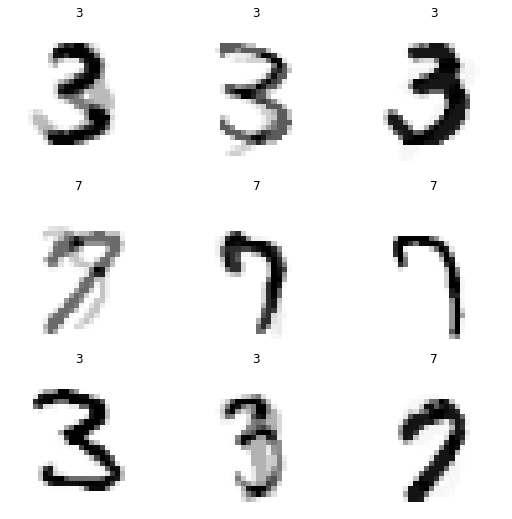

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
dbunch.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

## Not Flattened

In [ ]:
tds = DataSource(items, [PILImageBW.create, [parent_label, MultiCategorize(), OneHotEncode()]], splits=GrandparentSplitter()(items))
dbunch = tds.databunch(after_item=[ToTensor(), IntToFloatTensor()])

from local.vision.models.xresnet import xresnet18
from local.vision.learner import create_cnn_model

mixup = MixUp(0.5)

m = create_cnn_model(partial(xresnet18, c_in=1), 2, None, False)
learn = Learner(dbunch, m, loss_func=BCEWithLogitsLossFlat(), cbs=mixup)

learn.fit(1)

## Flattened

In [ ]:
mixup = MixUp(0.5)
m = create_cnn_model(partial(xresnet18, c_in=1), 2, None, False)
loss_func = BaseLoss(nn.BCEWithLogitsLoss, flatten=False, floatify=True, is_2d=False, activation=torch.sigmoid)
learn = Learner(dbunch, m, loss_func=loss_func, cbs=mixup)

learn.fit(1)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_transform.ipynb.
Converted 02_script.ipynb.
Converted 03_torch_core.ipynb.
Converted 03a_layers.ipynb.
Converted 04_dataloader.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 21_vision_learner.ipynb.
Converted 22_tutorial_imagenette.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Conve